[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gsarti/lcl23-xnlm-lab/blob/main/notebooks/1.2_Probing.ipynb)

# **Probing Transformer Internal Representations**

In this notebook, we will see how to train a probing model to assess the amount of linguistic knoweldge encoded in a pre-trained version of a Transformer model. More specifically, we will test whether and how sentence-level morpho-syntactic and syntatic properites are implicitly encoded in the internal representations of a BERT model.

This notebook is adapted from the experiments devised in "*Linguistic Profiling of a Neural Language Model*" (Miaschi et al., 2020, https://aclanthology.org/2020.coling-main.65.pdf) and is structured as follows:

*  **Part 1**: Loading of the model and the dataset we will use to perform the probing experiments;
* **Part 2**: Extraction of the internal representations from the model;
* **Part 3**: Training of the probing model;
* **Part 4**: Evaluation and visualization of the results.

## **Probing Tasks**

“*We take a model that was trained on some task, such as a language model. We generate representations using the model, and train another classifier that takes the representations and predicts some property. If the classifier performs well, we say that the model has learned information relevant for the property.*” (Probing Classifiers: Promises, Shortcomings, and Advances, Belinkov Y., 2022, https://direct.mit.edu/coli/article/48/1/207/107571/Probing-Classifiers-Promises-Shortcomings-and).

<div>
  <img src="https://alemiaschi.github.io/files/probing_tasks.png" width="1000">
</div>

In this tutorial, we will be focusing on training a probing model that utilizes a linear regressor. The model leverages BERT sentence-level representations to predict the value of a set of linguistic features automatically extracted from gold annotated sentences.

## **1. Installation and imports**

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
#from google.colab import drive

import pickle

import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# AutoModel and AutoTokenizer for loading the Transformer model (and the corresponding tokenizer) via Huggingface's Transformers library
from transformers import AutoModel, AutoTokenizer

# Imports for the probing model
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyRegressor

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

## **1. Loading the model**

We will use a pre-trained version of the BERT model (12 layers, 12 attention heads, 768 hidden units), available through the [Transformers](https://huggingface.co/docs/transformers/index) library. However, it is possible to use any other model from those available from the Huggingface Model: [Huggingface Models](https://huggingface.co/models).

Along with the model, we also load the corresponding tokenizer.

### **1.1 BERT architecture**

<div>
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200420231335/elmo-eemmbeddings.jpg" width="800">
</div>

(Source: https://www.geeksforgeeks.org/explanation-of-bert-model-nlp/)

In [4]:
model_name = "bert-base-uncased"

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Loading the tokenizer and the model via Huggingface's Transformers library
tokenizer = AutoTokenizer.from_pretrained(model_name)

# We set 'output_hidden_states' equal to 'True' because we want to extract the representations from all the layers of the model
model = AutoModel.from_pretrained(model_name, output_hidden_states=True)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## **2. Dataset**

In this notebook, we employ a dataset comprising sentences extracted from the GUM Corpus (Zeldes A., 2017, https://gucorpling.org/amir/pdf/GUM_paper_prepub.pdf). GUM, the Georgetown University Multilayer corpus, is an open source collection of richly annotated texts from multiple text types. 

We chose this dataset since it has been annotated according to the [Universal Dependencies](https://universaldependencies.org/) formalism. Therefore, it allows the extraction of gold linguistc properites from the annotated sentences.

The UD English GUM is available at the following link: https://universaldependencies.org/treebanks/en_gum/index.html.

In [ ]:
drive.mount('/content/drive')

### **2.1. Data Investigation**

Before proceeding with the data processing, let's examine the structure of the dataset more closely.

In [6]:
sentences_file = "../data/GUM_Treebank_Sentences.tsv"

df = pd.read_csv(sentences_file, delimiter='\t', header=None)

df.head()

,0,1
0,GUM_academic_exposure-1,Introduction
1,GUM_academic_exposure-2,Research on adult-learned second language (L2)...
2,GUM_academic_exposure-3,"Of interest here, studies suggest that, despit..."
3,GUM_academic_exposure-4,"However, it is not enough to have attained suc..."
4,GUM_academic_exposure-5,"Crucially, it is also desirable to retain them..."


In [7]:
tot_sentences = len(df)
print("Total number of sentences:", tot_sentences)

Total number of sentences: 5153


## **3. Extraction of the internal representations**

After loading the model and the dataset, we can extract BERT's internal representations. First, we need to tokenize each individual sequence (i.e. sentence) using the tokenizer:

```python
input_ids = tokenizer.encode(<sentence>, add_special_tokens=True)
```
We set the parameter '*add_special_tokens*' equal to '*True*' because we want to add the '*\[CLS]*' and '*\[SEP]*' tokens defined in the model's vocabulary.

<div>
  <img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*ktkqnCsFx1VPmCNYUOUAyw.png" width="800">
</div>

(Source: https://towardsdatascience.com/sentence-correctness-classifier-using-transfer-learning-with-huggingface-bert-8884795ba5ca)


Then, we can extract the representations as follows:

```python
outputs = model(input_ids)
```


In [8]:
embeddings = []
ids = []
sentences = []

# Extracting the representations from each sentence of the probing dataset, with model(*input_ids*), where *input_ids* corresponds to the tokenized sentence
with open(sentences_file, 'r') as f:
  for line in f:
    elements = line.rstrip('\n').split('\t')
    sent_id = elements[0]
    sentence = elements[1]

    # Tokenization of the sentence
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    input_ids = torch.tensor([input_ids]).to(device)

    # Extraction of the representations
    with torch.no_grad():
      outputs = model(input_ids)
      embeddings.append(outputs["hidden_states"])
      ids.append(sent_id)
      sentences.append(sentence)

# Saving the representations 
#with open("../data/GUM_Treebank_Representations.pkl", "wb") as fOut:
#  pickle.dump({'ids': ids, 'sentences': sentences, 'embeddings': embeddings}, fOut)

### **3.1. Exploring Model output**

In the following, we examine more closely the output of the extraction process (e.g. number of layers, struture of the output).


In [9]:
sample_sentence = sentences[300]
sample_tokens = tokenizer.tokenize(sample_sentence, add_special_tokens=True)
sample_embedding = embeddings[300]

# Visualize the output of the tokenization process on the sample sentence extracted from the dataset
print("Tokens:", sample_tokens)
print()

# Number of layers of the model
n_layers = len(sample_embedding)
print("Numer of layers:", n_layers)
print()

# Word representations of a specific selected layer
layer = 12
hidden_state = sample_embedding[layer]
print(hidden_state)
print()

# Visualize the dimension of the 'hidden_state' object (i.e. number of sentences * number of tokens * number of hidden units)
dim_hidden_state = hidden_state.shape
print("Tensor dimension:", dim_hidden_state)
print()

# Visualize the embedding of a specific token of the selected sample sentence
word_embeddings = {k:v for k, v in zip(sample_tokens, hidden_state[0])}
print(word_embeddings["reason"])

Tokens: ['[CLS]', 'the', 'reason', 'for', 'it', 'is', 'because', 'people', 'were', 'fighting', 'for', 'our', 'land', ',', 'either', 'defending', 'it', 'or', 'extending', 'it', ',', 'because', 'that', 'was', 'the', 'main', 'source', '.', '[SEP]']

Numer of layers: 13

tensor([[[ 0.0757,  0.0164, -0.1568,  ..., -0.3808,  0.2195,  0.4642],
         [ 0.0765, -0.1931, -0.1814,  ..., -0.1002,  0.5683,  0.4332],
         [-0.8869,  0.4616, -0.1631,  ..., -0.0199, -0.5137,  0.3742],
         ...,
         [ 0.3685,  0.4208, -0.4885,  ..., -0.2029, -0.4166, -0.1863],
         [ 0.6282,  0.2763, -0.3411,  ...,  0.0072, -0.4181, -0.4368],
         [ 0.0877,  0.6951,  0.1139,  ..., -0.0176, -0.3817, -0.1705]]])

Tensor dimension: torch.Size([1, 29, 768])

tensor([-8.8689e-01,  4.6162e-01, -1.6312e-01, -3.7560e-01,  6.2536e-01,
         3.0484e-01,  6.2627e-01,  1.1932e+00, -6.8599e-01, -3.9991e-01,
         3.6593e-01, -6.5737e-01, -7.5233e-01,  7.6856e-01, -1.6948e-01,
         2.5790e-01,  7.26

## **4. Extraction of the linguistic (probing) features**

As already mentioned, each probing task will consist in predicting the value of a set of linguistic features automatically extracted from the GUM annotated sentences.

The set of features used in the notebook was extracted using ***Profiling-UD*** (Brunato et al., 2020, http://www.lrec-conf.org/proceedings/lrec2020/pdf/2020.lrec-1.883.pdf), a text analysis tool inspired to the principles of linguistic profiling that allows the extraction of more than 130 features, spanning across different levels of linguistic annotation. 

In particular, these features model linguistic phenomena ranging from raw text ones, to morpho–syntactic information and inflectional properties of verbs, to more complex aspects of sentence structure modeling global and local properties of the whole parsed tree and of specific subtrees, such as the order of subjects and objects with respect to the verb, the distribution of UD syntactic relations, and more.

<div>
  <img src="https://alemiaschi.github.io/files/features.png" width="1000">
</div>


Profiling-UD is available at the following link: http://linguistic-profiling.italianlp.it/. 

### **4.1. Loading the dataset with the linguistic features**

In the following, we load and explore our dataset, which has already processed with the Profiling-UD tool. However, it is possible to replicate these experiments by using a different set of sentences and uploading them to Profiling-UD in order to extract the linguistic features to probe the Transformer model.

In [10]:
# Loading the dataset with the linguistic features extracted with ProfilingUD
df = pd.read_csv("../data/GUM_Treebank_Features.tsv", sep='\t')
df = df.set_index("identifier")
df.head()

,n_sentences,n_tokens,tokens_per_sent,char_per_tok,upos_dist_DET,upos_dist_ADV,upos_dist_VERB,upos_dist_NOUN,upos_dist_PART,upos_dist_NUM,...,subordinate_pre,subordinate_post,verb_edges_dist_1,verb_edges_dist_3,verb_edges_dist_4,verb_edges_dist_2,verb_edges_dist_0,verb_edges_dist_6,verb_edges_dist_5,avg_verb_edges
identifier,,,,,,,,,,,,,,,,,,,,,
GUM_academic_exposure-1,1,1,1.0,12.000000,0.000000,0.000000,0.000000,100.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
GUM_academic_exposure-2,1,32,32.0,5.960000,6.250000,0.000000,6.250000,28.125000,0.000000,6.250000,...,0.0,100.0,50.0,50.0,0.000000,0.000000,0.0,0.0,0.000000,2.000000
GUM_academic_exposure-3,1,35,35.0,5.740741,2.857143,2.857143,8.571429,25.714286,0.000000,5.714286,...,0.0,100.0,0.0,0.0,33.333333,33.333333,0.0,0.0,33.333333,3.666667
GUM_academic_exposure-4,1,13,13.0,5.000000,0.000000,7.692308,7.692308,7.692308,15.384615,0.000000,...,0.0,100.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.000000,2.000000
GUM_academic_exposure-5,1,23,23.0,4.500000,8.695652,13.043478,4.347826,17.391304,4.347826,0.000000,...,0.0,100.0,0.0,0.0,0.000000,100.000000,0.0,0.0,0.000000,2.000000


## **5. Train the probing model**

Below is reported the function for training the probing model. The function takes as input the following arguments:
* BERT internal representations;
* The dataframe with the linguistic features extracted with Profiling-UD;
* The ids of the sentences in the original dataset;
* The BERT layer from which extract the representation as input features of the probing model;
* The linguistic feature to be used as prediction label of the probing model.

**Preprocessing**: Before starting the actual training process, it is necessary to obtain an aggregated representation of each sentence in our dataset using the BERT token-level representations. For instance, we can apply a mean pooling strategy to compute the average of all token representations in each sentence. In our case, to obtain the embeddings representations for our sentence-level tasks we used for each of its 12 layers the activation of the first input token ('*\[CLS]*'), which is generally used as classification token and somehow summarizes the information from the actual tokens, as suggested in "*What does BERT learn about the structure of language?*" (Jawahar et al., 2019, https://aclanthology.org/P19-1356.pdf).

**Train/test split**: Next, we split the dataset into training and test sets, using an 80% split for training and a 20% split for the test set (cross-fold validation could also be performed if desired).

**Model definition and training**: Finally, we train the probing model. The chosen model for these experiments is a linear Support Vector Regressor (LinearSVR). We opt for a linear model to keep it as simple as possible and avoid interference with the linguistic properties implicitly encoded in the model representations. Since the features to predict are continuous, the model is set up as a regressor.

**Evaluation**: Upon completion of the training, we can evaluate the predictions using commonly used regression metrics (e.g., mean squared error (MSE), R-squared (R2) or Spearman correlation). In our case, we use Spearman correlation, but other metrics can also be tested for performance evaluation.

In [11]:
def probing(embeddings, df, ids, feature, layer):

  # Dataset containing only the selected linguistic feature
  df_feature = df[feature]

  X = []
  y = []
  
  for id, sentence in zip(ids, embeddings):
    embedding_layer = sentence[layer][0]

    # We extract the representation from the [CLS] token, that is the first token in each input sequence, having set 'add_special_tokens' equal to 'True' during tokenization
    cls_embedding = embedding_layer[0].tolist()

    # Access to the value of the linguistic feature 'feature' for the given sentence, based on the id
    feat = df_feature.loc[id]

    X.append(cls_embedding)
    y.append(feat)

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, ids, test_size=0.20, random_state=42)

  # Defining the probing model
  probing_model = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)

  # Save the predictions for further analysis
  df_preds = pd.DataFrame(columns=["sent_id", 
                                   "y_true", 
                                   "y_pred"])
  df_preds["sent_id"] = ids_test
  df_preds["y_true"] = y_test
  df_preds["y_pred"] = y_pred
  df_preds.to_csv(f'../data/results_{layer}_{feature}.tsv', 
                  sep='\t', index=True)
  
  return corr, p_val

### **5.1. Baseline model**

To ensure a meaningul comparison of the results, we define a baseline model (LinearSVR) that exclusively relies on the length of the input sentences to predict the set of linguistic features. This baseline serves as a reference point for evaluating the performance of the probing models trained with BERT internal representations.

In [12]:
def baseline(df, feature):
  # Select "n_tokens" as X for the baseline probing model
  X = df["n_tokens"].to_numpy()
  X = X.reshape(-1, 1)
  y = df[feature].to_numpy()

  # Diving the dataset into train and test files
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
  
  # Defining the probing model
  probing_model = LinearSVR(dual=False, loss='squared_epsilon_insensitive')
  
  # Fit the model on the training data and then predict on X_test
  probing_model.fit(X_train, y_train)
  y_pred = probing_model.predict(X_test)

  # Evaluation of the predictions
  corr, p_val = spearmanr(y_test, y_pred)
  
  return corr, p_val

Once the two functions for training the probing model and the baseline have been defined, we can execute the probing tasks, one for each layer of the model and for each lingusitic feature extracted with Profiling-UD.

Below is the code to perform the probing tasks on all 12 layers of BERT and on a set of 6 linguistic features extracted with Profiling-UD:
* *n_tokens*: total number of tokens;
* *char_per_tok*: average number of characters per word (excluded punctuation);
* *upos_dist_NOUN*: distribution of nouns in the sentence;
* *upos_dist_VERB*: distribution of verbs in the sentence;
* *avg_token_per_clause*: average clause length, calculated in terms of the average number of tokens per clause, where a clause is defined as the ratio between the number of tokens in a sentence and the number of either verbal or copular head; 
* *avg_subordinate_chain_len*: average length of subordinate chains, where a subordinate 'chain' is calculated as the number of subordinate clauses embedded on a first subordinate clause.

Feel free to customize the code according to your requirements, such as executing it selectively on specific layers, distinct groups of features, or even on all of them.

In [13]:
selected_features = ["n_tokens", 
                     "char_per_tok", 
                     "upos_dist_NOUN", 
                     "upos_dist_VERB", 
                     "avg_token_per_clause", 
                     "avg_subordinate_chain_len"
                     ]

layers = list(range(n_layers)[1:])

# Create an empty pandas DataFrame to store the probing results
results = pd.DataFrame(index=selected_features, columns=layers + ["Baseline"])

# Iterate over the selected features
for feature in selected_features:
  # Iterate over the 12 layers of the model
  for layer in layers:
    corr, p_val = probing(embeddings, df, ids, feature, layer)

    # Save the score only if the correlation is statistically significant (p-value < 0.05)
    if p_val < 0.05:
      results.loc[feature][layer] = corr

  # Simple baseline model trained to predict the selected linguistic feature using only "n_tokens" as input feature
  corr_baseline, p_val_baseline = baseline(df, feature)
  if p_val < 0.05:
    results.loc[feature]["Baseline"] = corr_baseline

## **6. Results visualization**

We can now look at the results that we previously stored in a DataFrame and compare with respect to the '*n_tokens*' baseline.

Since we have performed the probing tasks using representations extracted from all 12 layers of the model, we can also explore the progression across the layers, from the input (1) to the output one (12).

In [14]:
# Visualize the results memorized in the DataFrame
results

,1,2,3,4,5,6,7,8,9,10,11,12,Baseline
n_tokens,0.990812,0.989576,0.988145,0.982168,0.971336,0.961379,0.945926,0.937147,0.939375,0.934813,0.925843,0.919626,1.0
char_per_tok,0.739853,0.748602,0.746031,0.729927,0.66928,0.640196,0.583172,0.582061,0.550919,0.564811,0.546866,0.558774,-0.08138
upos_dist_NOUN,0.697179,0.71566,0.74901,0.766281,0.756462,0.770728,0.748331,0.713599,0.732016,0.722192,0.68072,0.645216,-0.038892
upos_dist_VERB,0.642125,0.668414,0.724502,0.749218,0.737134,0.741821,0.720013,0.704305,0.7032,0.674628,0.681722,0.550223,-0.045091
avg_token_per_clause,0.724917,0.731751,0.732388,0.719989,0.71966,0.712989,0.726106,0.686361,0.71692,0.665632,0.650959,0.650067,0.553152
avg_subordinate_chain_len,0.743092,0.760478,0.770249,0.756293,0.742003,0.740605,0.733927,0.713321,0.718466,0.701982,0.673835,0.655855,0.602162


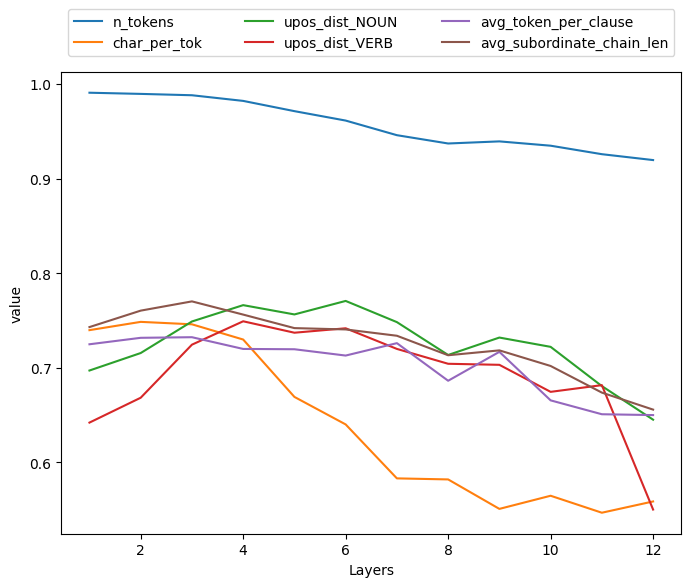

In [15]:
# Formatting the dataframe in order to be visualized as a multiline plot
results = results[layers]
results = results.T
results["Layers"] = results.index
plot_results = pd.melt(results, ["Layers"])

# Visualization with seaborn
fig, ax = plt.subplots(figsize=(8, 6))
g = sns.lineplot(data=plot_results, x="Layers", y="value", hue="variable")
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 1.02, 1., .102),
              loc='lower left', ncol=3, mode="expand")